In [1]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.simulate_transients import SimulateGenericTransient

In [6]:
#tophat + two component
def combined_signal(time, redshift, av, bands, num_points, noise, thv, loge0, thc, logn0, p, logepse, logepsb, ksin, g0, mej1, mej2,
                   vej1, vej2, kappa1, kappa2, temp_floor1, temp_floor2 ):
    """
    Function to combine afterglow and kilonova model flux densities
    Time specified is max time
    """
    frequency = np.array(redback.utils.bands_to_frequency(bands))
    times= np.linspace(0.01,time,100)
    
    model_kwargs = {'output_format':'flux_density', 'frequency':frequency}
    
    afterglow_params={}
    afterglow_params['base_model']= 'tophat'
    afterglow_params['redshift'] = redshift
    afterglow_params['av'] = av
    afterglow_params['loge0'] = loge0
    afterglow_params['logn0'] = logn0 
    afterglow_params['p'] = p
    afterglow_params['logepse'] = logepse
    afterglow_params['logepsb'] = logepsb
    afterglow_params['ksin'] = ksin
    afterglow_params['g0'] = g0
    afterglow_params['thv']= thv
    afterglow_params['thc'] = thc
    
    kilonova_params={}
    kilonova_params['base_model']= 'two_component_kilonova_model'
    kilonova_params['redshift'] = redshift
    kilonova_params['av']= av
    kilonova_params['mej_1'] = mej1
    kilonova_params['temperature_floor_1'] = temp_floor1 #min temp of expanding photosphere
    kilonova_params['kappa_1'] = kappa1 
    kilonova_params['vej_1'] = vej1
    kilonova_params['mej_2'] = mej2 
    kilonova_params['temperature_floor_2'] = temp_floor2 
    kilonova_params['kappa_2'] = kappa2
    kilonova_params['vej_2'] = vej2
    
    afterglow_obs= SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=afterglow_params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)

    kn_obs= SimulateGenericTransient(model='extinction_with_kilonova_base_model', parameters=kilonova_params,times=times, 
                                     data_points=num_points, model_kwargs=model_kwargs, multiwavelength_transient=True,
                                     noise_term=noise)
    
    merged_data = pd.concat([afterglow_obs.data, kn_obs.data],ignore_index=True)
    print(merged_data)
    
    transient = redback.transient.Transient(name='my_transient', flux_density=merged_data['output'].values,
                                      time=merged_data['time'].values, data_mode='flux_density',
                                      flux_density_err=merged_data['output_error'].values, frequency=merged_data['frequency'].values)
    return transient


         time     frequency   true_output        output  output_error
0    0.010000  3.087381e+14  1.025365e-28  1.071667e-28  5.126825e-30
1    0.514949  3.972879e+14  9.939762e-18  1.103330e-17  4.969881e-19
2    0.514949  6.210931e+14  4.713681e-18  4.373716e-18  2.356841e-19
3    1.524848  3.087381e+14  1.591782e-14  1.680216e-14  7.958911e-16
4    3.039697  3.087381e+14  1.410445e-12  1.409806e-12  7.052225e-14
..        ...           ...           ...           ...           ...
95  46.465354  3.972879e+14  2.882174e-04  2.892833e-04  1.441087e-05
96  46.465354  6.210931e+14  2.878480e-06  2.906630e-06  1.439240e-07
97  46.970303  3.087381e+14  1.412727e-03  1.341857e-03  7.063635e-05
98  48.485152  3.449498e+14  7.651496e-04  6.913090e-04  3.825748e-05
99  48.990101  3.087381e+14  1.430375e-03  1.523944e-03  7.151876e-05

[100 rows x 5 columns]


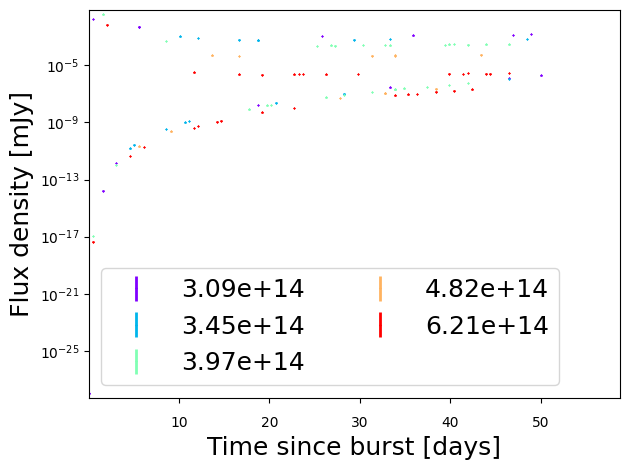

<Axes: xlabel='Time since burst [days]', ylabel='Flux density [mJy]'>

In [7]:
bands = ['lsstg', 'lsstr', 'lssti','lsstz','lssty']
transient= combined_signal(50, 0.01, 1, bands, 50, 0.05, 0.5, 52.5, 0.01, -2, 2.1, -1, -1, 0.4, 1000.0, 0.015, 0.01,
                           0.1, 0.2, 1.0, 25.0, 2000, 2000)

transient.plot_data(filters=transient.unique_frequencies)


In [8]:
afterglow_params={}
afterglow_params['base_model']= 'tophat'
afterglow_params['loge0'] = 49.5
afterglow_params['logn0'] = -0.5 
afterglow_params['p'] = 2.13
afterglow_params['logepse'] = -1.25
afterglow_params['logepsb'] = -2.5
afterglow_params['ksin'] = 1
afterglow_params['g0'] = 1000
afterglow_params['thv']= 0.4
afterglow_params['thc'] = 0.6
afterglow_params['frequency']=4e14
    
kilonova_params={}
kilonova_params['base_model']= 'two_layer_stratified_kilonova'
kilonova_params['mej'] = 0.03
kilonova_params['beta'] = 4 
kilonova_params['kappa'] = 3
kilonova_params['vej_1']=0.1
kilonova_params['vej_2'] = 0.4
kilonova_params['frequency']=4e14


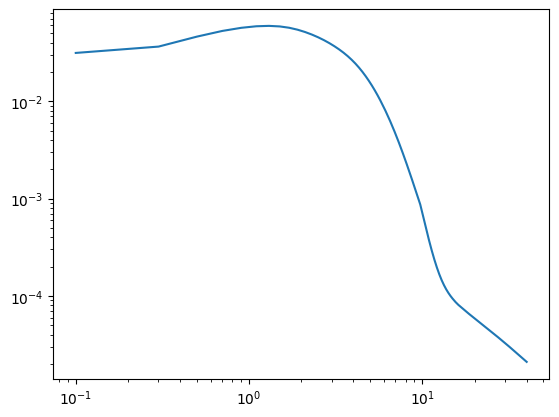

In [9]:
time=np.linspace(0.1,40,200)
test_flux = redback.transient_models.combined_models.afterglow_and_optical(time=time, redshift=0.01, av=0.5, model_type= 'kilonova',
                                                                          output_format='flux_density', afterglow_kwargs=afterglow_params,
                                                                          optical_kwargs=kilonova_params)
ax=plt.subplot()
ax.loglog(time,test_flux)

In [10]:
times= np.linspace(0.1,40,200)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

ag={}
ag['loge0'] = 49.5
ag['logn0'] = 0.5 
ag['p'] = 2.3
ag['logepse'] = -1.25
ag['logepsb'] = -2.5
ag['ksin'] = 1
ag['g0'] = 1000
ag['thv']= 0.5
ag['thc'] = 0.6
ag['base_model']='tophat'

kn={}
kn['mej']=0.03
kn['vej_1']=0.1
kn['vej_2']=0.4
kn['kappa']=2
kn['beta']=4
kn['base_model']='two_layer_stratified_kilonova'


parameters = {'redshift':0.01, 'av':0.5, 'model_type':'kilonova', 'afterglow_kwargs':ag, 'optical_kwargs':kn}
model_kwargs= {'frequency':frequencies, 'output_format':'flux_density'}

combined_model =  SimulateGenericTransient(model='afterglow_and_optical', parameters=parameters,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs,
                                            multiwavelength_transient=True, noise_term=noise)
combined_model.data

[1.94770377e+14 2.57913110e+14 3.08738117e+14 3.44949775e+14
 3.97287891e+14 4.81730482e+14 6.21093083e+14 8.16711950e+14
 1.14683976e+15]


time     frequency   true_output        output  output_error
0     0.300503  2.000000e+17  1.953432e-04  1.901886e-04  9.767162e-06
1     0.300503  3.449498e+14  6.672072e-02  6.444938e-02  3.336036e-03
2     0.300503  5.000000e+09  1.614341e+01  1.634384e+01  8.071707e-01
3     0.501005  2.000000e+17  9.315529e-05  9.612015e-05  4.657765e-06
4     0.501005  2.000000e+17  9.315529e-05  8.971957e-05  4.657765e-06
..         ...           ...           ...           ...           ...
495  39.799497  5.000000e+09  3.431198e-02  3.605026e-02  1.715599e-03
496  39.799497  6.210931e+14  9.745062e-06  9.376584e-06  4.872531e-07
497  39.799497  1.947704e+14  3.373094e-05  3.232434e-05  1.686547e-06
498  40.000000  2.000000e+17  1.478364e-07  1.531836e-07  7.391819e-09
499  40.000000  4.817305e+14  1.340942e-05  1.410457e-05  6.704712e-07

[500 rows x 5 columns]

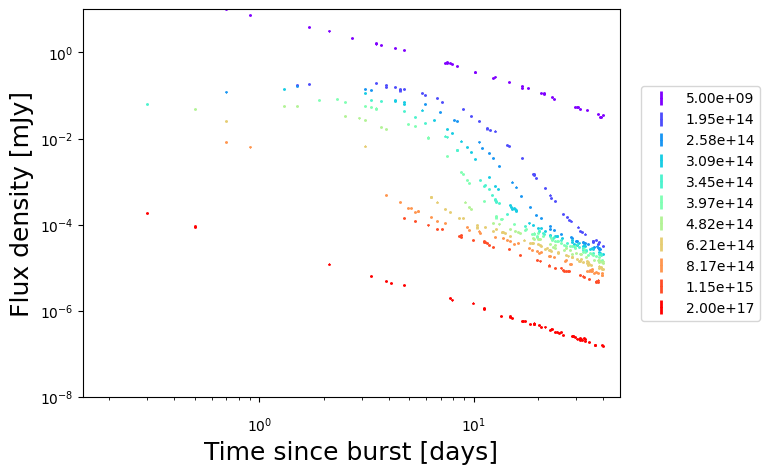

In [11]:
transient = redback.transient.Transient(name='my_transient', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)
    
ax= transient.plot_data(filters=transient.unique_frequencies, show=False)
ax.set_ylim(10e-9,10)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

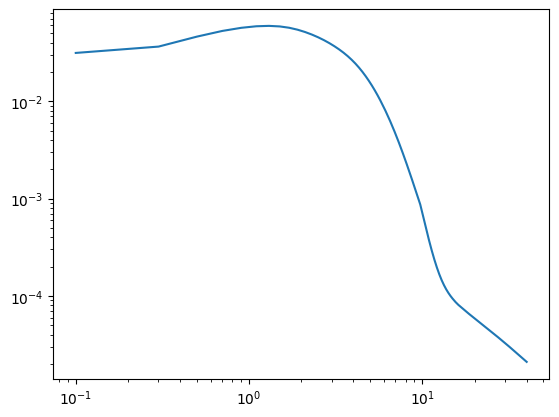

In [30]:
time=np.linspace(0.1,40,200)

flux=redback.transient_models.combined_models.tophat_and_twolayerstratified(time,redshift=0.01,av=0.5,thv=0.4, loge0=49.5, thc=0.6, 
            logn0=-0.5, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, mej=0.03, output_format='AB_mag', frequency=4e14,
            kappa=3, beta=4, vej_1=0.1, vej_2=0.4)

ax= plt.subplot()
ax.loglog(time,flux)
plt.show()

In [2]:
times= np.linspace(0.1,40,200)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}

params={}
params['redshift'] = 0.01
params['av'] = 0.5
params['loge0'] = 49.5
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['ksin'] = 1
params['g0'] = 1000
params['thv']= 0.5
params['thc'] = 0.6
params['mej']=0.03
params['vej_1']=0.1
params['vej_2']=0.4
params['kappa']=2
params['beta']=4
    
combined_model =  SimulateGenericTransient(model='tophat_and_twolayerstratified', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)
combined_model.data

[1.94770377e+14 2.57913110e+14 3.08738117e+14 3.44949775e+14
 3.97287891e+14 4.81730482e+14 6.21093083e+14 8.16711950e+14
 1.14683976e+15]


time     frequency   true_output        output  output_error
0     0.100000  2.000000e+17  9.761603e-04  1.069471e-03  4.880802e-05
1     0.100000  3.449498e+14  1.005154e-01  1.007370e-01  5.025772e-03
2     0.100000  5.000000e+09  1.297195e+01  1.199792e+01  6.485975e-01
3     0.300503  2.000000e+17  1.953422e-04  1.875783e-04  9.767112e-06
4     0.300503  2.000000e+17  1.953422e-04  2.022014e-04  9.767112e-06
..         ...           ...           ...           ...           ...
495  39.598995  5.000000e+09  3.462259e-02  3.469773e-02  1.731129e-03
496  39.598995  6.210931e+14  9.833280e-06  9.762146e-06  4.916640e-07
497  40.000000  1.947704e+14  3.337165e-05  3.221901e-05  1.668582e-06
498  40.000000  2.000000e+17  1.478337e-07  1.543236e-07  7.391685e-09
499  40.000000  4.817305e+14  1.341146e-05  1.202310e-05  6.705731e-07

[500 rows x 5 columns]

Meta data does not exist for this event.


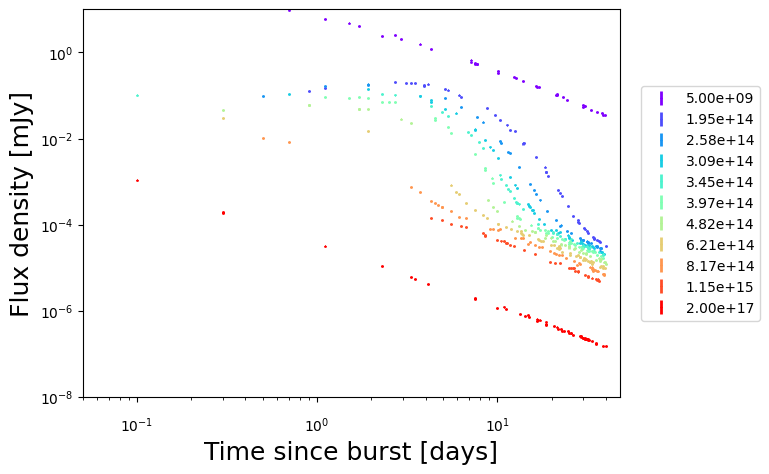

In [9]:
transient = redback.transient.Afterglow(name='my_transient', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)
    
ax= transient.plot_data(filters=frequencies, show=False)
ax.set_ylim(10e-9,10)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [12]:
transient.unique_frequencies

array([5.00000000e+09, 1.94770377e+14, 2.57913110e+14, 3.08738117e+14,
       3.44949775e+14, 3.97287891e+14, 4.81730482e+14, 6.21093083e+14,
       8.16711950e+14, 1.14683976e+15, 2.00000000e+17])

In [10]:
model='two_layer_stratified_kilonova'
injection_parameters= params
model_kwargs = dict(frequency=transient.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors(model=model)
priors['redshift']=0.01
priors

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/encodings/unicode_escape.py:26: DeprecationWarning: invalid escape sequence '\m'
  return codecs.unicode_escape_decode(input, errors, final)


{'redshift': 0.01,
 'mej': Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None),
 'vej_1': Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None),
 'vej_2': Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None),
 'kappa': Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None),
 'beta': Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)}

In [59]:
result = redback.fit_model(transient=transient, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)


14:04 bilby INFO    : Running for label 'my_transient', output will be saved to 'kilonova//two_layer_stratified_kilonova'
14:04 bilby INFO    : Analysis priors:
14:04 bilby INFO    : mej=Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None)
14:04 bilby INFO    : vej_1=Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None)
14:04 bilby INFO    : vej_2=Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None)
14:04 bilby INFO    : kappa=Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None)
14:04 bilby INFO    : beta=Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
14:04 bilby INFO    : redshift=0.01
14:04 bilby INFO    : Analysis likelihood class: <class 'redback.likelihoods.GaussianLikelihood'>
14:04 bilby INFO    : Analysis

it=  8563 logz=-8.129839889314


14:07 bilby INFO    : Sampling time: 0:03:27.169776
14:07 bilby INFO    : Summary of results:
nsamples: 9564
ln_noise_evidence: -94887.249
ln_evidence: -7.630 +/-  0.087
ln_bayes_factor: 94879.619 +/-  0.087



In [11]:
result_knonly = redback.fit_model(transient=transient, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)


06:02 bilby INFO    : Running for label 'GRBmy_transient', output will be saved to 'GRBData/afterglow/flux_density//two_layer_stratified_kilonova'
06:02 bilby INFO    : Analysis priors:
06:02 bilby INFO    : mej=Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None)
06:02 bilby INFO    : vej_1=Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None)
06:02 bilby INFO    : vej_2=Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None)
06:02 bilby INFO    : kappa=Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None)
06:02 bilby INFO    : beta=Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
06:02 bilby INFO    : redshift=0.01
06:02 bilby INFO    : Analysis likelihood class: <class 'redback.likelihoods.GaussianLikelihood'>
06:02

1it [00:00, ?it/s]

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log

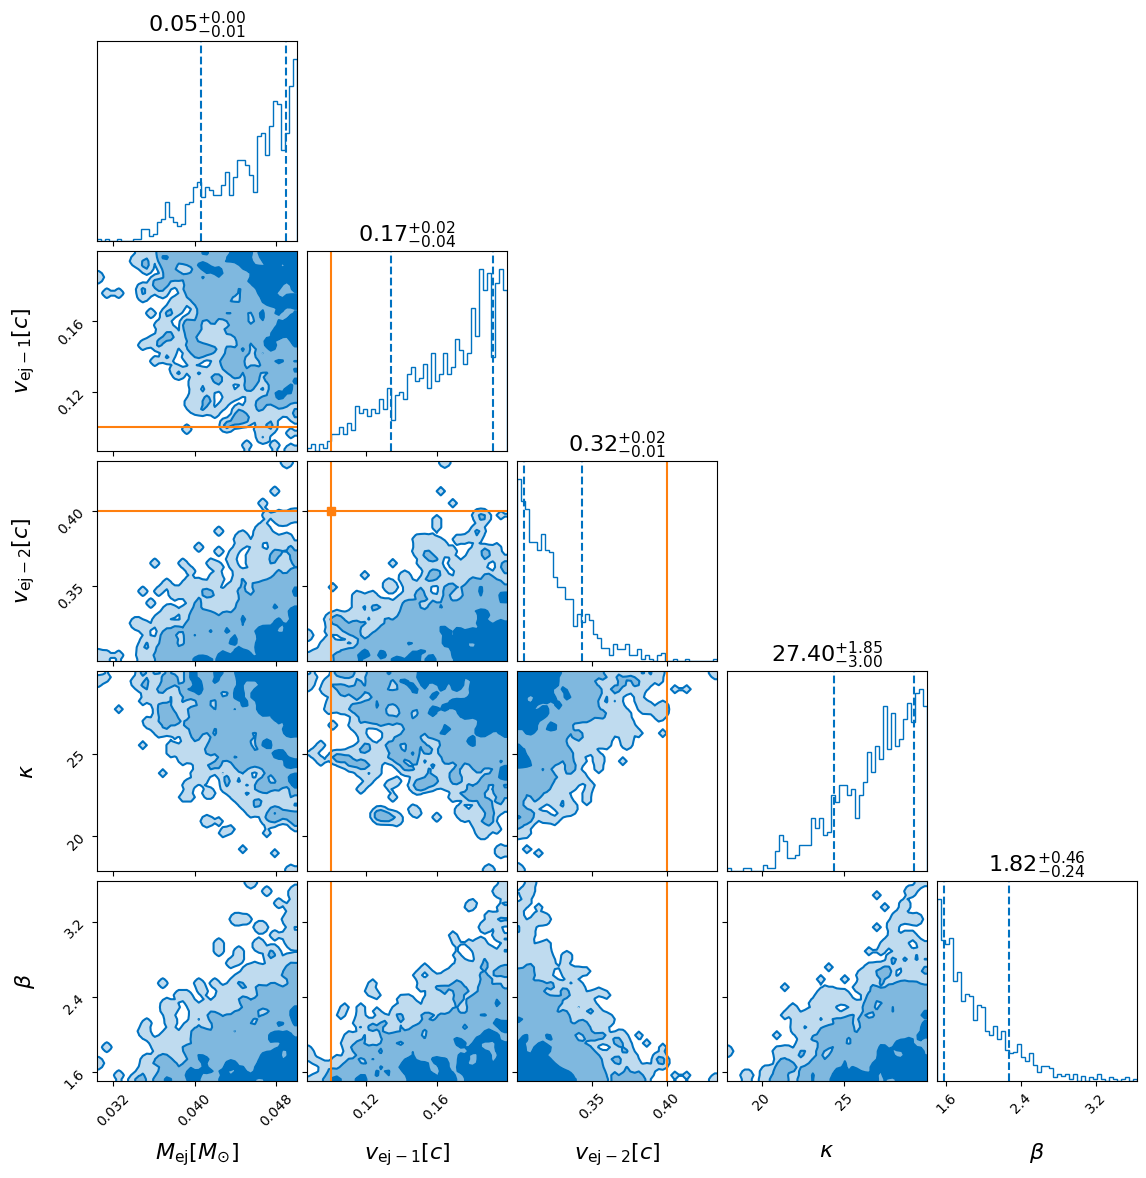

In [12]:
result_knonly.plot_corner()

Meta data does not exist for this event.
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heati

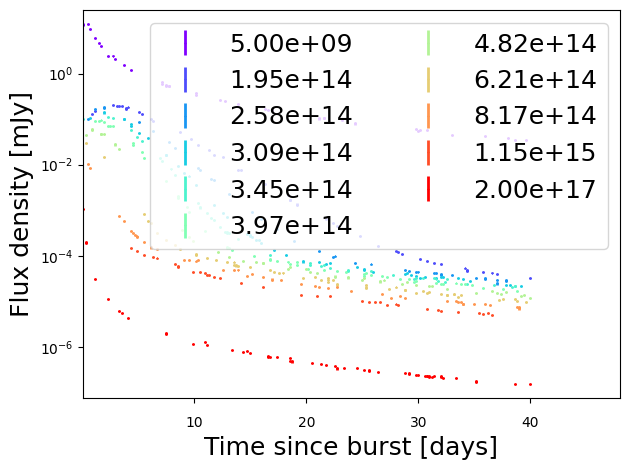

<Axes: xlabel='Time since burst [days]', ylabel='Flux density [mJy]'>

In [13]:
result_knonly.plot_lightcurve()

In [14]:
result_knonly.posterior

mej     vej_1     vej_2      kappa      beta  redshift  \
0    0.049590  0.192479  0.353941  29.039812  2.456649      0.01   
658  0.049015  0.139711  0.302047  29.744925  2.369476      0.01   
659  0.035100  0.147581  0.304683  28.133633  1.558382      0.01   
660  0.047442  0.187090  0.322765  26.868757  2.708757      0.01   
661  0.049461  0.158328  0.318608  27.536045  2.387748      0.01   
..        ...       ...       ...        ...       ...       ...   
339  0.044430  0.137293  0.308153  29.898819  2.244498      0.01   
340  0.049711  0.178228  0.345496  28.049942  1.670599      0.01   
341  0.046867  0.140900  0.356979  27.447022  1.770428      0.01   
328  0.036934  0.195642  0.300051  27.981665  1.625470      0.01   
999  0.048377  0.153811  0.354568  29.979401  1.643276      0.01   

     log_likelihood  log_prior  
0               0.0   1.486336  
658             0.0   1.486336  
659             0.0   1.486336  
660             0.0   1.486336  
661             0.0   1.486336  
..              ...        ...  
339             0.0   1.486336  
340             0.0   1.486336  
341             0.0   1.486336  
328             0.0   1.486336  
999             0.0   1.486336  

[1000 rows x 8 columns]

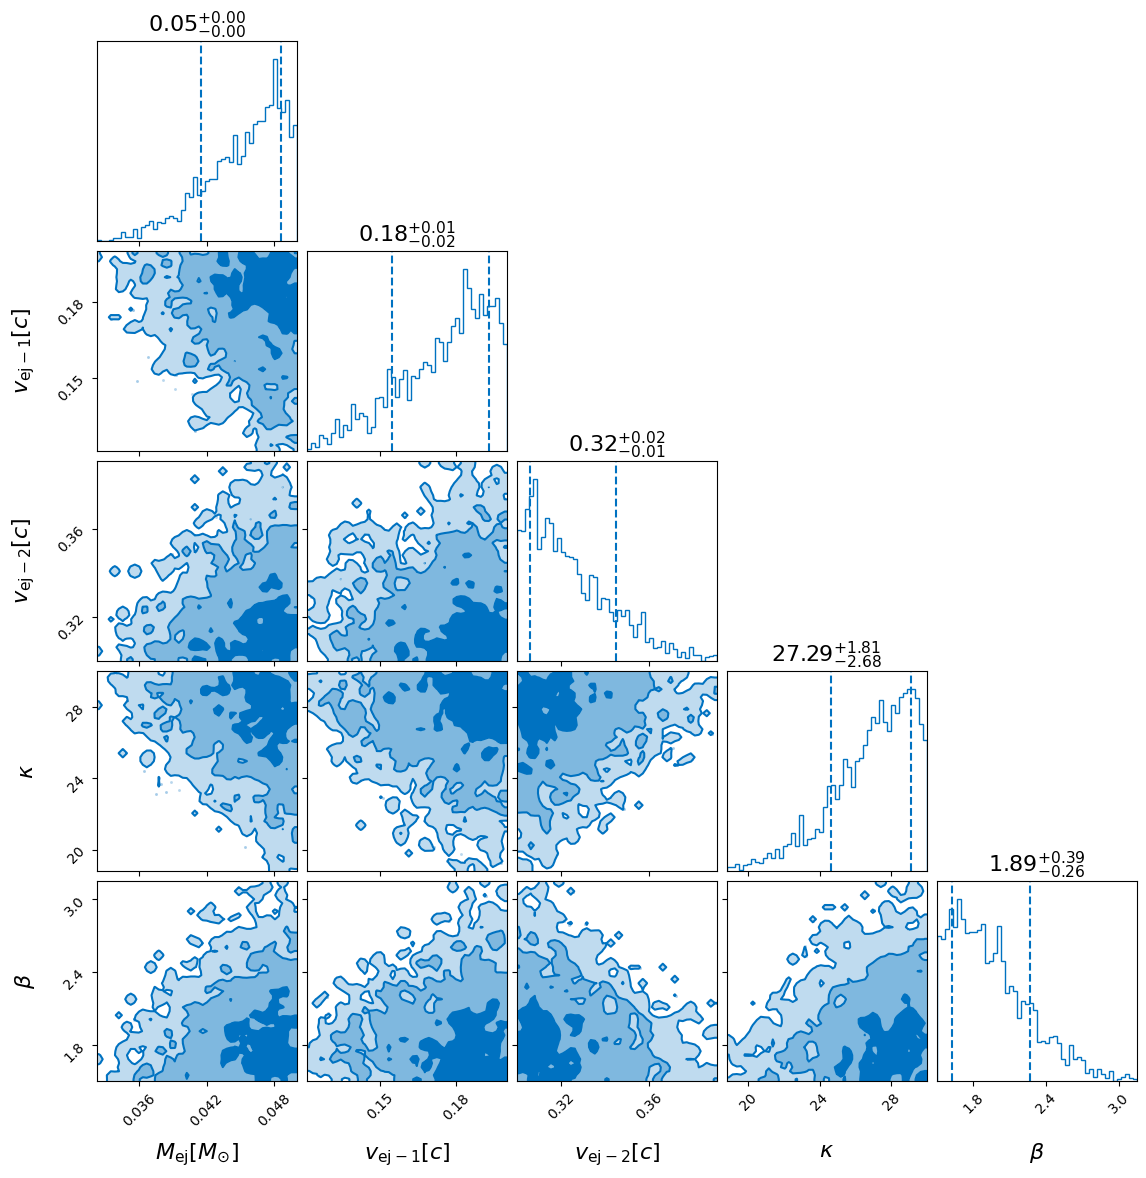

In [60]:
result.plot_corner()

[Errno 2] No such file or directory: 'kilonova//my_transient_metadata.csv'
Setting metadata to None
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anac

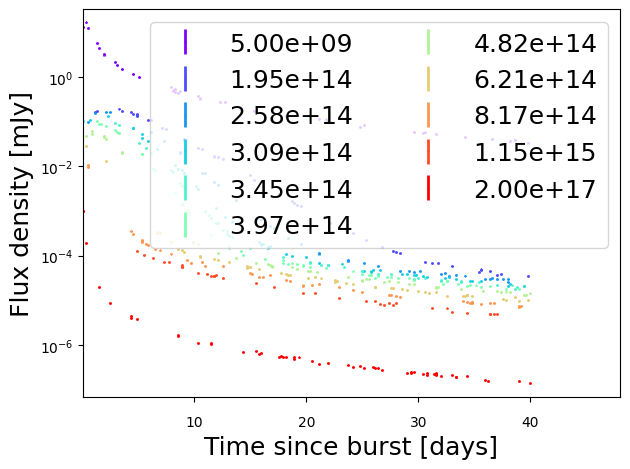

In [61]:
ax=result.plot_lightcurve(show=False)
ax.loglog()
plt.show()

In [63]:
result.posterior

mej     vej_1     vej_2      kappa      beta  redshift  \
0     0.044349  0.167730  0.333544  29.271598  2.319463      0.01   
6373  0.039918  0.158394  0.307142  26.058868  1.860436      0.01   
6374  0.049473  0.190591  0.316231  22.901978  2.264040      0.01   
6375  0.049473  0.190591  0.316231  22.901978  2.264040      0.01   
6376  0.049473  0.190591  0.316231  22.901978  2.264040      0.01   
...        ...       ...       ...        ...       ...       ...   
3188  0.043117  0.195972  0.303114  24.265454  2.034241      0.01   
3189  0.043117  0.195972  0.303114  24.265454  2.034241      0.01   
3190  0.043117  0.195972  0.303114  24.265454  2.034241      0.01   
3192  0.041061  0.183732  0.312536  22.126709  1.644543      0.01   
9563  0.043067  0.198964  0.307847  29.698164  1.520842      0.01   

      log_likelihood  log_prior  
0                0.0   1.486336  
6373             0.0   1.486336  
6374             0.0   1.486336  
6375             0.0   1.486336  
6376             0.0   1.486336  
...              ...        ...  
3188             0.0   1.486336  
3189             0.0   1.486336  
3190             0.0   1.486336  
3192             0.0   1.486336  
9563             0.0   1.486336  

[9564 rows x 8 columns]

In [19]:
transient2 = redback.transient.Afterglow(name='my_transient2', flux_density=combined_model.data['output'].values,
                                      time=combined_model.data['time'].values, data_mode='flux_density',
                                      flux_density_err=combined_model.data['output_error'].values, frequency=combined_model.data['frequency'].values)

Meta data does not exist for this event.


In [20]:
model2='tophat'
injection_parameters= params
model_kwargs = dict(frequency=transient2.filtered_frequencies, output_format='flux_density')
that_priors = redback.priors.get_priors(model=model2)
that_priors['redshift']=0.01
that_priors

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/encodings/unicode_escape.py:26: DeprecationWarning: invalid escape sequence '\m'
  return codecs.unicode_escape_decode(input, errors, final)


{'redshift': 0.01,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': Uniform(minimum=0.0, maximum=1.0, name='ksin', latex_label='$\\xi_{N}$', unit=None, boundary=None),
 'g0': Uniform(minimum

In [21]:
result2 = redback.fit_model(transient=transient2, model=model2, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=that_priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)

06:23 bilby INFO    : Running for label 'GRBmy_transient2', output will be saved to 'GRBData/afterglow/flux_density//tophat'
06:23 bilby INFO    : Analysis priors:
06:23 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)
06:23 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
06:23 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None)
06:23 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
06:23 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
06:23 bilby INFO    : logepse=Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None)
06:23 bilby

25588it [00:00, ?it/s]

RuntimeError: Slice sampler has failed to find a valid point. Some useful output quantities:
u: [0.00245854 0.75101901 0.86439767 0.01570549 0.38818915 0.38476287
 0.90492018 0.20184519 0.50027106]
nstep_left: -5e-324
nstep_right: 5e-324
nstep_hat: 1e-323
u_prop: [0.00245854 0.75101901 0.86439767 0.01570549 0.38818915 0.38476287
 0.90492018 0.20184519 0.50027106]
loglstar: -19772.231642036448
logl_prop: <dynesty.utils.LoglOutput object at 0x7ffad0075e50>
direction: [-9.48714351e-08  3.64746067e-03  4.64398433e-03 -4.88185128e-03
  1.85458182e-03 -1.01009061e-02  9.29394391e-04 -3.72595170e-02
 -1.04696899e-02]


In [ ]:
result2.plot_corner()

In [ ]:
ax= result2.plot_lightcurve(show=False)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [22]:
model3='tophat_and_twolayerstratified'
injection_parameters= params
model_kwargs = dict(frequency=transient2.filtered_frequencies, output_format='flux_density')
all_priors = redback.priors.get_priors(model=model3)
all_priors['redshift']=0.01
all_priors

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/encodings/unicode_escape.py:26: DeprecationWarning: invalid escape sequence '\m'
  return codecs.unicode_escape_decode(input, errors, final)


{'redshift': 0.01,
 'av': Uniform(minimum=0, maximum=2, name='av', latex_label='$av$', unit=None, boundary=None),
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': Uniform(minimum=0.0, maximu

In [23]:
result3 = redback.fit_model(transient=transient2, model=model3, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=all_priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)

06:29 bilby INFO    : Running for label 'GRBmy_transient2', output will be saved to 'GRBData/afterglow/flux_density//tophat_and_twolayerstratified'
06:29 bilby INFO    : Analysis priors:
06:29 bilby INFO    : av=Uniform(minimum=0, maximum=2, name='av', latex_label='$av$', unit=None, boundary=None)
06:29 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)
06:29 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
06:29 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}$', unit=None, boundary=None)
06:29 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
06:29 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
06:29 bilby INFO    

1it [00:00, ?it/s]

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log

07:37 bilby INFO    : Summary of results:
nsamples: 1000
ln_noise_evidence: -95000.410
ln_evidence: -6.475 +/-  0.212
ln_bayes_factor: 94993.935 +/-  0.212



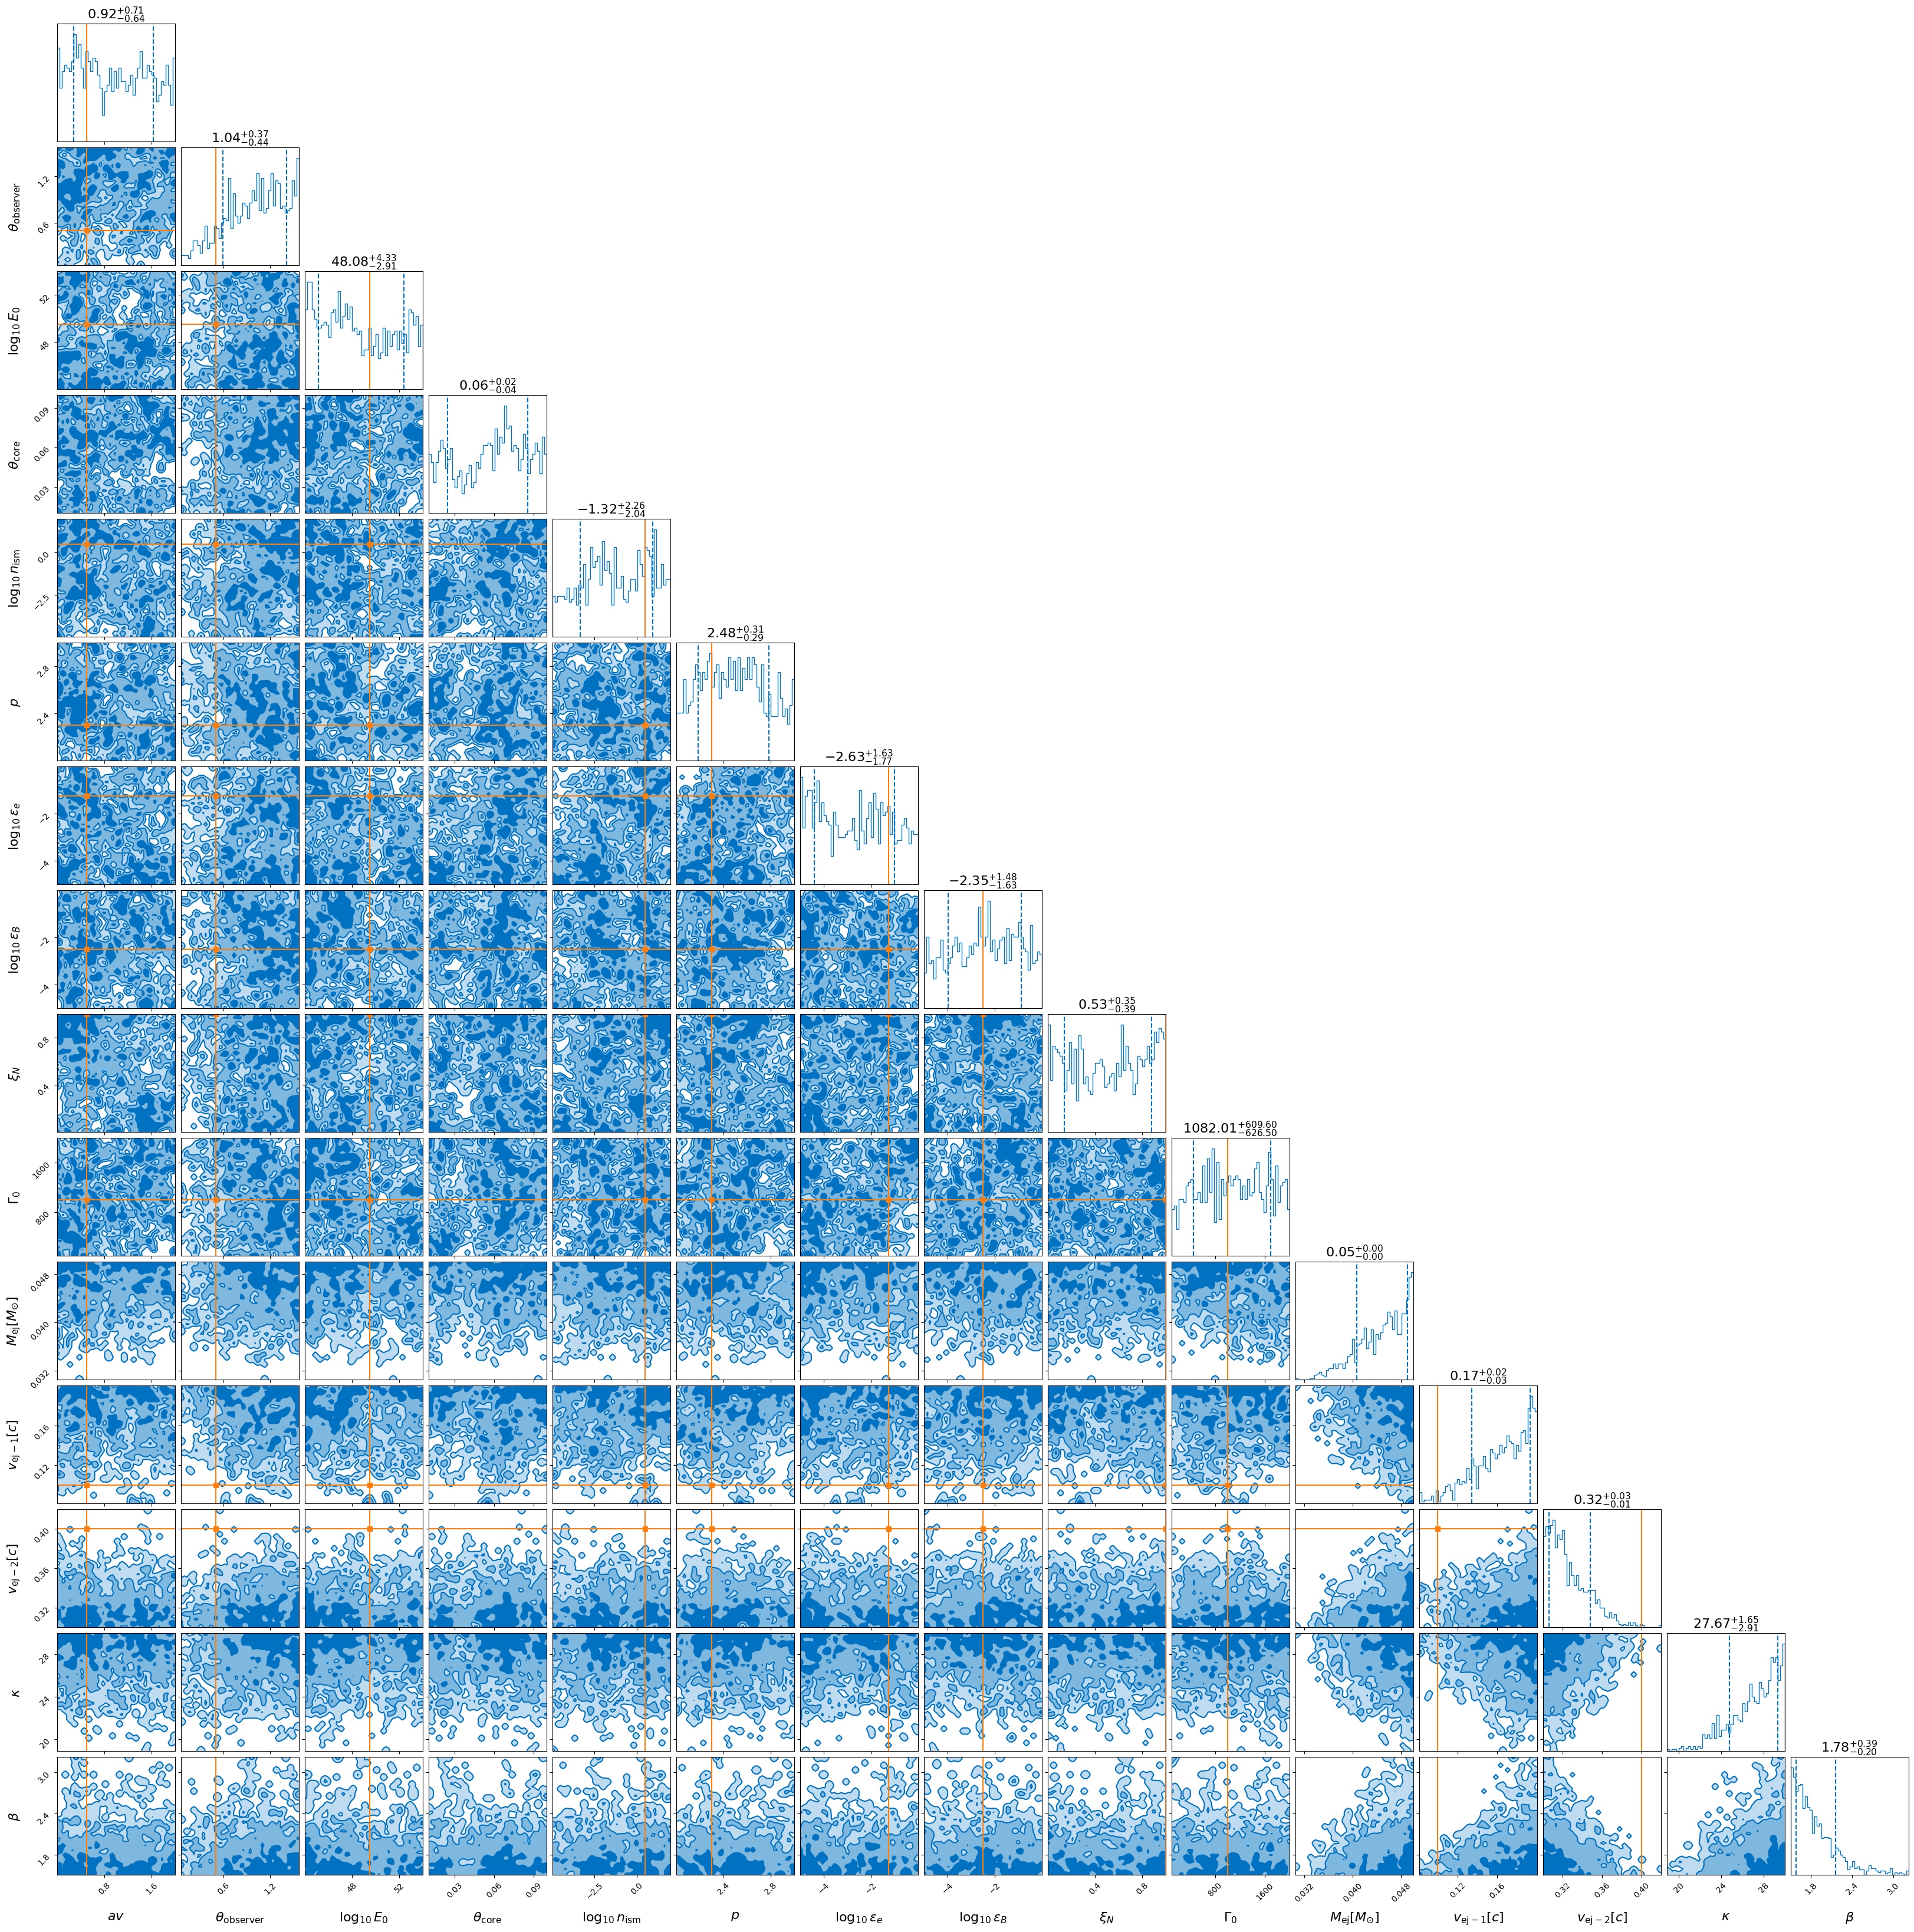

In [24]:
result3.plot_corner()

Meta data does not exist for this event.
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heating_rate/__init__.py:182: RuntimeWarning: divide by zero encountered in log
  np.log(out.t[1:]), np.log(LL[1:]), kind='cubic', assume_sorted=True)
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/kilonova_heati

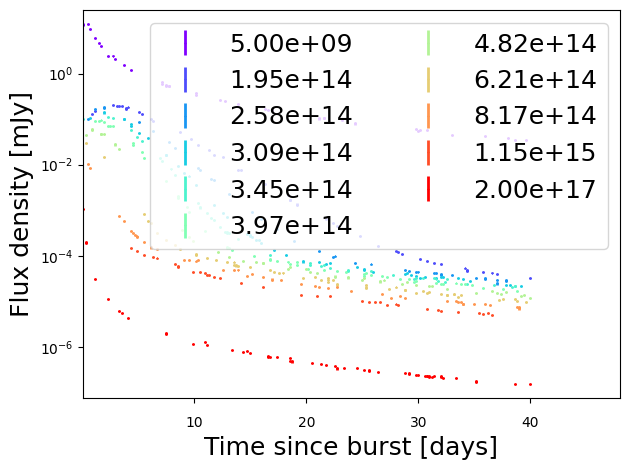

<Axes: xlabel='Time since burst [days]', ylabel='Flux density [mJy]'>

In [25]:
result3.plot_lightcurve()

In [29]:
result3.posterior

av       thv      loge0       thc     logn0         p   logepse  \
0    0.573999  0.941224  47.723373  0.085309 -4.621768  2.712221 -3.586477   
658  0.988260  1.064535  44.868589  0.084307 -3.880534  2.521940 -0.687059   
659  1.089669  0.673849  47.777536  0.095248 -0.820218  2.085773 -3.184987   
660  1.024665  1.353653  44.666328  0.068885 -1.028374  2.007278 -3.052531   
661  0.853708  1.441715  44.767024  0.070130 -2.407262  2.222031 -3.172359   
..        ...       ...        ...       ...       ...       ...       ...   
339  0.040056  1.291648  47.758269  0.039722 -0.961684  2.560059 -4.397050   
340  0.416101  0.682643  53.381254  0.060922 -1.256546  2.659934 -0.487298   
341  0.171288  0.818942  53.966007  0.056062 -3.112631  2.490738 -2.891147   
328  0.644234  1.522133  47.761655  0.029502 -2.451615  2.965238 -1.319898   
999  1.540282  1.320229  51.833264  0.062069 -0.898955  2.333018 -3.709951   

      logepsb      ksin           g0       mej     vej_1     vej_2      kappa  \
0   -3.574588  0.119065   575.661502  0.049020  0.153187  0.302072  25.864698   
658 -1.554023  0.325978  1451.928394  0.048902  0.137310  0.311468  24.612296   
659 -0.287722  0.841496   463.226664  0.045688  0.122972  0.317900  23.549819   
660 -3.335281  0.012034   597.494850  0.043629  0.144780  0.309978  26.351977   
661 -3.437080  0.062634   680.063080  0.039404  0.153661  0.303734  27.122502   
..        ...       ...          ...       ...       ...       ...        ...   
339 -2.677067  0.806270  1509.663971  0.044866  0.183022  0.392312  27.500322   
340 -4.245979  0.481611   624.902547  0.041386  0.162943  0.302036  22.252548   
341 -1.477334  0.603917  1780.475086  0.043431  0.143488  0.300975  27.913101   
328 -3.574846  0.127286   455.568678  0.044251  0.169764  0.330393  29.233986   
999 -2.535505  0.697182   320.655768  0.049374  0.147608  0.335426  28.694911   

         beta  redshift  log_likelihood  log_prior  
0    1.581256      0.01             0.0 -12.721841  
658  1.644992      0.01             0.0 -12.643024  
659  1.586753      0.01             0.0 -12.980600  
660  2.078264      0.01             0.0 -12.532756  
661  2.019588      0.01             0.0 -12.517347  
..        ...       ...             ...        ...  
339  1.560122      0.01             0.0 -12.548472  
340  1.508099      0.01             0.0 -12.969687  
341  1.521106      0.01             0.0 -12.823124  
328  1.618949      0.01             0.0 -12.510178  
999  1.732128      0.01             0.0 -12.540719  

[1000 rows x 18 columns]

In [30]:
all_priors['av']=0.5

In [31]:
result4 = redback.fit_model(transient=transient2, model=model3, sampler='nestle', model_kwargs=model_kwargs,
                           prior=all_priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)